<a href="https://colab.research.google.com/github/musicjae/Img_projects/blob/main/Inception%20series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### TIP

- 상단에서 <런타임> 클릭 / 런타임 유형 변경 / GPU 선택  
- 코랩은 일정 시간이 지나면 런타임이 중단된다. 그러면 임시 저장된 학습되었던 것, 실행되었던 것 등이 사라진다. 이것을 방지하기 위해, "코랩 연결 끊김 방지"를 실행한다.  
  - F12 누름 / Console 창에서 아래 코드를 붙여 넣고 엔터:  
    -  function ClickConnect(){
    console.log("코랩 연결 끊김 방지"); 
    document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect, 60 * 1000)


## 0 유틸 도구  
  
- 코랩 폴더 내의 데이터 개수 확인 함수

In [ ]:
import cv2
from pathlib import Path
path=Path("/content/drive/MyDrive/dataset/img_classfication/animal faces/animal/data/tiger")
#path=path.glob("*.jpg")
images=[]
cnt = 0
for imagepath in path.glob('*.png'):
    cnt += 1

print(cnt)    

240


### 0.2 구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 0.6 임포트

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from PIL import Image
from keras.optimizers import Adam
from keras.applications import InceptionV3
from keras.applications import ResNet50
from keras.applications import vgg19
from keras.applications import xception
from keras.applications import NASNetLarge
from keras.models import load_model
from keras import layers
import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard as K

import io
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from keras.utils.vis_utils import plot_model
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True


## Dataset


- target_size:   
  - (299,299) 사용은 inception V3 에서 최상단 레이어 연결하는 경우: include_top = True 인 경우  
  
  - (200,200) 사용은 False 인 경우에 사용. 다른 shape으로 바꿔 사용해도 됨

In [ ]:
train = ImageDataGenerator(rescale = 1/255,validation_split=0.3)

train_dataset = train.flow_from_directory('/content/drive/MyDrive/dataset/img_classfication/animal faces/animal/data',
                                          target_size = (100,100),
                                          batch_size = 32,
                                          shuffle=True,
                                          class_mode='categorical',
                                          subset='training') 

val_dataset = train.flow_from_directory('/content/drive/MyDrive/dataset/img_classfication/animal faces/animal/data',
                                          target_size = (100,100),
                                          batch_size = 32,
                                          shuffle=False,
                                          class_mode='categorical',
                                          subset='validation') 


Found 2199 images belonging to 11 classes.
Found 938 images belonging to 11 classes.


In [ ]:
val_dataset.class_indices

{'chicken': 0,
 'cow': 1,
 'dog': 2,
 'horse': 3,
 'monkey': 4,
 'mouse': 5,
 'pig': 6,
 'rabbit': 7,
 'sheep': 8,
 'snake': 9,
 'tiger': 10}

## Vanila CNN

In [ ]:
cnn = keras.models.Sequential([
                               keras.layers.Conv2D(64,7,activation='selu',padding="same",input_shape=[100,100,3]),
                               keras.layers.BatchNormalization(),
                               keras.layers.MaxPooling2D(2),

                               keras.layers.Conv2D(128,3,activation='selu',padding="same"),
                               keras.layers.BatchNormalization(),
                               keras.layers.Conv2D(128,3,activation='selu',padding="same"),
                               keras.layers.BatchNormalization(),
                               keras.layers.MaxPooling2D(2),

                               keras.layers.Conv2D(256,2,activation='selu',padding="same"),
                               keras.layers.BatchNormalization(),           
                               keras.layers.Conv2D(256,2,activation='selu',padding="same"),
                               keras.layers.BatchNormalization(),
                               keras.layers.Conv2D(512,2,activation='selu',padding="same"),
                               keras.layers.BatchNormalization(),           
                               keras.layers.Conv2D(512,2,activation='selu',padding="same"),
                               keras.layers.BatchNormalization(),
                               keras.layers.AveragePooling2D(2), 

                               keras.layers.Flatten(),
                               keras.layers.Dense(128,activation='selu'),
                               keras.layers.Dropout(0.3),
                               keras.layers.Dense(64,activation='selu'),
                               keras.layers.Dropout(0.3),
                               keras.layers.Dense(11,activation='softmax')

])

cnn.compile(loss="categorical_crossentropy" , optimizer= keras.optimizers.Adam(lr=1e-4), metrics=['accuracy']) # 모델 학습 시 어떤 것들을 사용할지 정함


In [ ]:
es = EarlyStopping(monitor='val_loss',patience=15,verbose=1,mode='min') # 조기종료: 일정 조건을 만족하면 epochs이 다 차지 않아도 조기 종료

cnn_history = cnn.fit(train_dataset,
                    validation_data = val_dataset, 
                      steps_per_epoch = 32,
                      epochs= 100,
                      callbacks=[es]) # 모델 학습

cnn.save('/content/drive/Shareddrives/dataset/test_cnn_0121_1.h5') # 모델 저장

32/32 [==============================] - 8s 235ms/step - loss: 0.1166 - accuracy: 0.9678 - val_loss: 2.3339 - val_accuracy: 0.6087


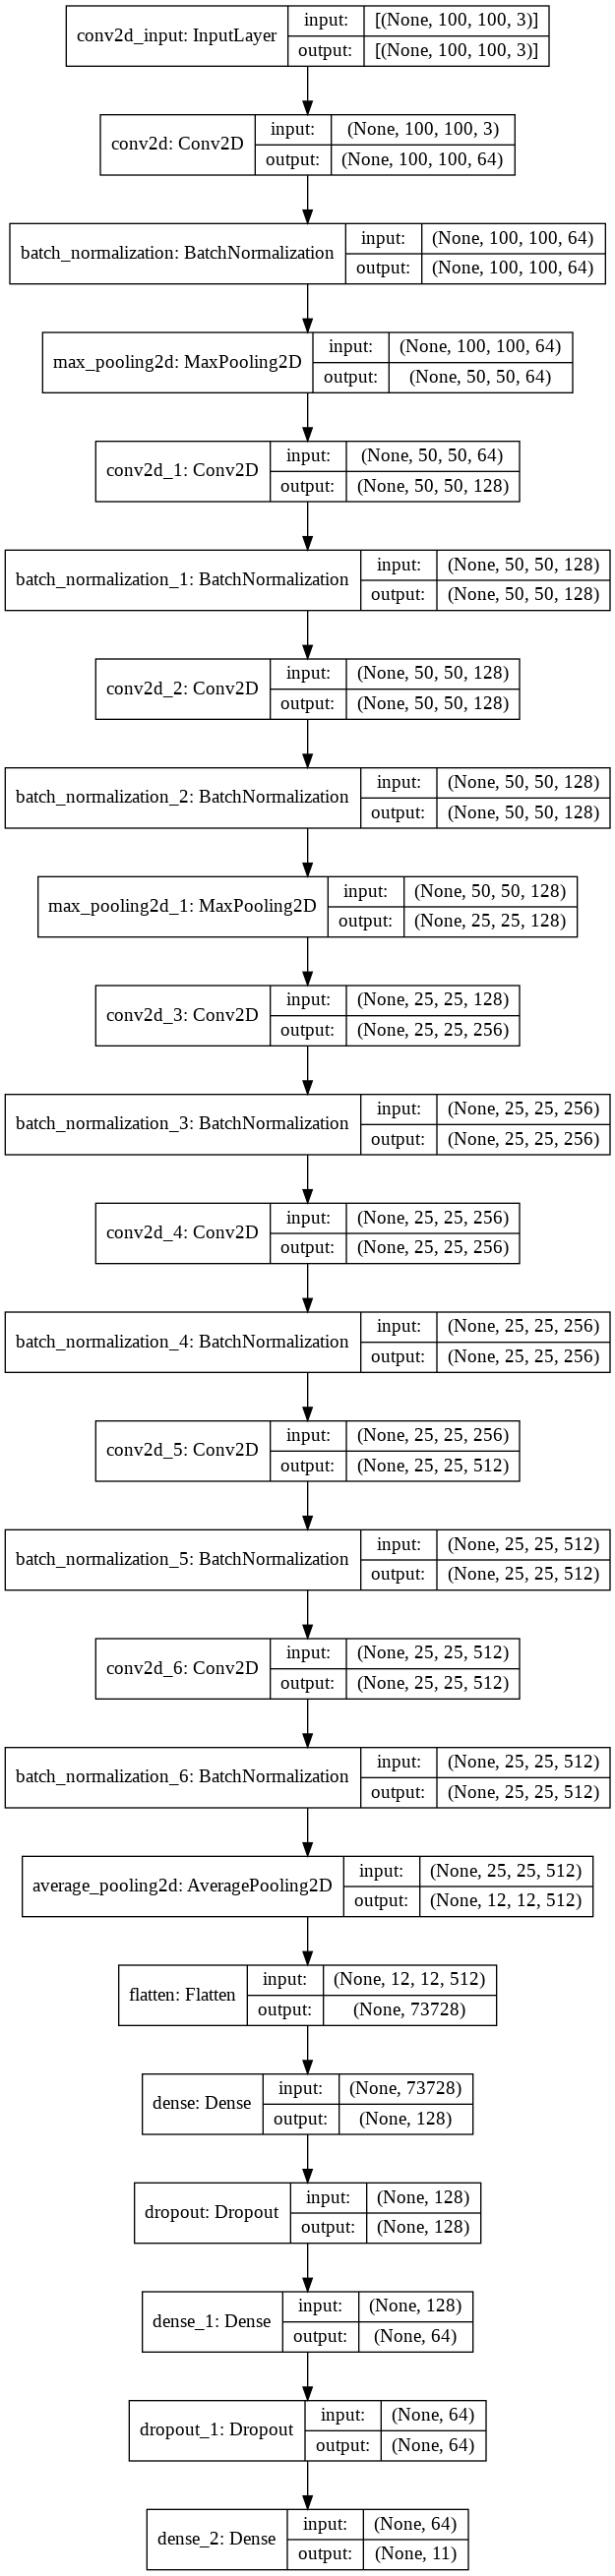

In [ ]:
plot_model(cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

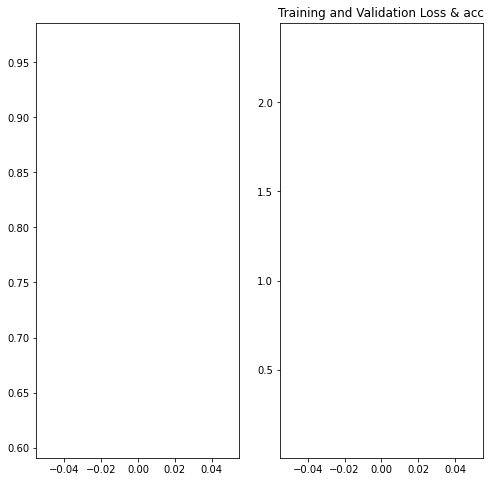

In [ ]:
acc = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']
loss= cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc,val_acc, label='Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,val_loss, label='Loss')


plt.title('Training and Validation Loss & acc')
plt.show()

## Inception V3  
  
- 텐서플로우를 백엔드로 사용하는 고수준 언어 케라스에서 제공하는 API를 전이학습 모델로 사용: Inception V3  
  
- 최하단 레이어는 출력되는 클래스의 개수에 맞춰주면 된다  
  - 보통 다중 분류인 경우에 "활성화 함수"로 softmax를 사용  
  - 보통 이진 분류인 경우에, 이 함수를 sigmoid로 사용

In [ ]:
use_model = keras.models.load_model('/content/drive/Shareddrives/dataset/test_inceptionv3_0121_1.h5')

In [ ]:
out = use_model.input
Inceptionv3 = InceptionV3(include_top=False,weights='imagenet',input_shape=(100,100,3))(out) # 구글에서 만든 우승 모델. 여러 모델 중 이번 task에서 가장 우수한 성능을 보이고, API로 제공되어 편리하게 사용할 수 있다.
#inputx = Inceptionv3.output # param num= 2048

flatten_layer = layers.Flatten() # 3차원 이상의 데이터를 2차원으로 평탄화flattening 시켜주기
x = flatten_layer(Inceptionv3)
x = layers.Dropout(0.5)(keras.activations.elu(x)) 

prediction = keras.layers.Dense(11,activation='softmax')(x) # 최하단을 분류 개수에 맞추기. (예) 12 동물 분류인 경우에, Dense(12, activation='softmax')(x)

model =keras.Model(out, prediction)
#model =keras.Model(Inceptionv3.input, prediction)

model.compile(loss="categorical_crossentropy" , optimizer= keras.optimizers.Adam(lr=1e-4), metrics=['accuracy']) # 모델 학습 시 어떤 것들을 사용할지 정함


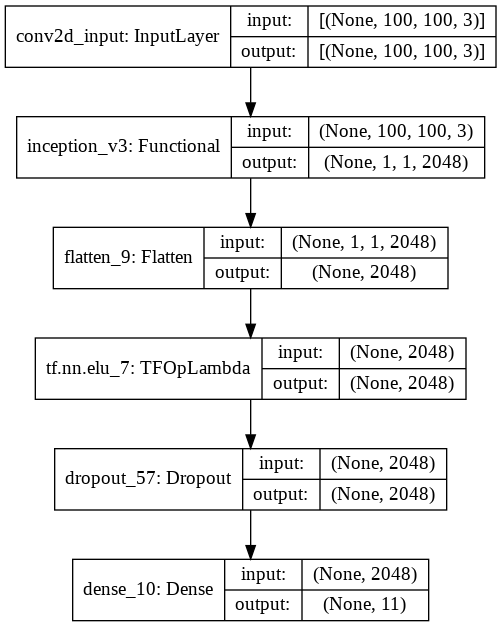

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
es = EarlyStopping(monitor='val_loss',patience=20,verbose=1,mode='min') # 조기종료: 일정 조건을 만족하면 epochs이 다 차지 않아도 조기 종료

history = model.fit(train_dataset,
                    validation_data = val_dataset, 
                      steps_per_epoch = 32,
                      epochs= 200,
                      callbacks=[es]) # 모델 학습

model.save('/content/drive/Shareddrives/dataset/test_inceptionv3_0121_2.h5') # 모델 저장

Epoch 1/200
32/32 [==============================] - 14s 280ms/step - loss: 2.4939 - accuracy: 0.1512 - val_loss: 2.1758 - val_accuracy: 0.3188
Epoch 2/200
32/32 [==============================] - 7s 213ms/step - loss: 2.1632 - accuracy: 0.2608 - val_loss: 1.8468 - val_accuracy: 0.4414
Epoch 3/200
32/32 [==============================] - 7s 222ms/step - loss: 1.8573 - accuracy: 0.3780 - val_loss: 1.6151 - val_accuracy: 0.4861
Epoch 4/200
32/32 [==============================] - 8s 244ms/step - loss: 1.4688 - accuracy: 0.5502 - val_loss: 1.2650 - val_accuracy: 0.5991
Epoch 5/200
32/32 [==============================] - 7s 217ms/step - loss: 1.1102 - accuracy: 0.6491 - val_loss: 1.0843 - val_accuracy: 0.6546
Epoch 6/200
32/32 [==============================] - 7s 228ms/step - loss: 0.8191 - accuracy: 0.7394 - val_loss: 0.9310 - val_accuracy: 0.7281
Epoch 7/200
32/32 [==============================] - 7s 211ms/step - loss: 0.5970 - accuracy: 0.8419 - val_loss: 0.7922 - val_accuracy: 0.752

## 학습 과정 확인하기

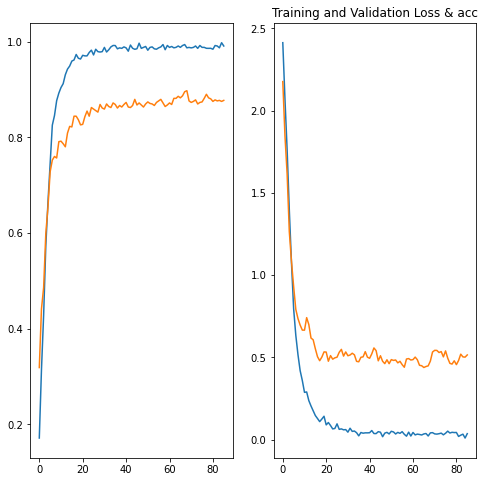

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc,val_acc, label='Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,val_loss, label='Loss')


plt.title('Training and Validation Loss & acc')
plt.show()

## Custom Inception V3 (modified)

In [ ]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

_KERAS_BACKEND = None
_KERAS_LAYERS = None
_KERAS_MODELS = None
_KERAS_UTILS = None


def get_submodules_from_kwargs(kwargs):
    backend = kwargs.get('backend', _KERAS_BACKEND)
    layers = kwargs.get('layers', _KERAS_LAYERS)
    models = kwargs.get('models', _KERAS_MODELS)
    utils = kwargs.get('utils', _KERAS_UTILS)
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils

def decode_predictions(*args, **kwargs):
    kwargs['backend'] = backend
    kwargs['utils'] = keras_utils
    return utils.decode_predictions(*args, **kwargs)
def _obtain_input_shape(input_shape,
                        default_size,
                        min_size,
                        data_format,
                        require_flatten,
                        weights=None):
    """Internal utility to compute/validate a model's input shape.
    # Arguments
        input_shape: Either None (will return the default network input shape),
            or a user-provided shape to be validated.
        default_size: Default input width/height for the model.
        min_size: Minimum input width/height accepted by the model.
        data_format: Image data format to use.
        require_flatten: Whether the model is expected to
            be linked to a classifier via a Flatten layer.
        weights: One of `None` (random initialization)
            or 'imagenet' (pre-training on ImageNet).
            If weights='imagenet' input channels must be equal to 3.
    # Returns
        An integer shape tuple (may include None entries).
    # Raises
        ValueError: In case of invalid argument values.
    """
    if weights != 'imagenet' and input_shape and len(input_shape) == 3:
        if data_format == 'channels_first':
            if input_shape[0] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[0]) + ' input channels.')
            default_shape = (input_shape[0], default_size, default_size)
        else:
            if input_shape[-1] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[-1]) + ' input channels.')
            default_shape = (default_size, default_size, input_shape[-1])
    else:
        if data_format == 'channels_first':
            default_shape = (3, default_size, default_size)
        else:
            default_shape = (default_size, default_size, 3)
    if weights == 'imagenet' and require_flatten:
        if input_shape is not None:
            if input_shape != default_shape:
                raise ValueError('When setting `include_top=True` '
                                 'and loading `imagenet` weights, '
                                 '`input_shape` should be ' +
                                 str(default_shape) + '.')
        return default_shape
    if input_shape:
        if data_format == 'channels_first':
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[0] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[1] is not None and input_shape[1] < min_size) or
                   (input_shape[2] is not None and input_shape[2] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
        else:
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[-1] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[0] is not None and input_shape[0] < min_size) or
                   (input_shape[1] is not None and input_shape[1] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
    else:
        if require_flatten:
            input_shape = default_shape
        else:
            if data_format == 'channels_first':
                input_shape = (3, None, None)
            else:
                input_shape = (None, None, 3)
    if require_flatten:
        if None in input_shape:
            raise ValueError('If `include_top` is True, '
                             'you should specify a static `input_shape`. '
                             'Got `input_shape=' + str(input_shape) + '`')
    return input_shape


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

from . import get_submodules_from_kwargs



WEIGHTS_PATH = (
    'https://github.com/fchollet/deep-learning-models/'
    'releases/download/v0.5/'
    'inception_v3_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = (
    'https://github.com/fchollet/deep-learning-models/'
    'releases/download/v0.5/'
    'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

backend = None
layers = None
models = None
keras_utils = None


def conv2d_bn(x,
              filters,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1),
              name=None):
    """Utility function to apply conv + BN.
    # Arguments
        x: input tensor.
        filters: filters in `Conv2D`.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv2D`.
        strides: strides in `Conv2D`.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.
    # Returns
        Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    if backend.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    x = layers.Conv2D(
        filters, (num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=False,
        name=conv_name)(x)
    x = layers.BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = layers.Activation('gelu', name=name)(x)
    x = layers.Dropout(0.3)(x)
    return x


def Modified_InceptionV3(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000,
                **kwargs):
 
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(
        input_shape,
        default_size=200,
        min_size=75,
        data_format=backend.image_data_format(),
        require_flatten=include_top,
        weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if backend.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3

    x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
    x = conv2d_bn(x, 32, 3, 3, padding='valid')
    x = conv2d_bn(x, 64, 3, 3)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv2d_bn(x, 80, 1, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, 3, padding='valid')
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # mixed 0: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed0')

    # mixed 1: 35 x 35 x 288
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed1')

    # mixed 2: 35 x 35 x 288
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed2')

    # mixed 3: 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(
        branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed3')

    # mixed 4: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed4')

    # mixed 5, 6: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = layers.AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch7x7, branch7x7dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 192, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed7')

    # mixed 8: 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                          strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(
        branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch7x7x3, branch_pool],
        axis=channel_axis,
        name='mixed8')

    # mixed 9: 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = layers.concatenate(
            [branch3x3_1, branch3x3_2],
            axis=channel_axis,
            name='mixed9_' + str(i))

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = layers.concatenate(
            [branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

        branch_pool = layers.AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch3x3, branch3x3dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(9 + i))
    if include_top:
        # Classification block
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='inception_v3')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            weights_path = keras_utils.get_file(
                'inception_v3_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                file_hash='9a0d58056eeedaa3f26cb7ebd46da564')
        else:
            weights_path = keras_utils.get_file(
                'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                file_hash='bcbd6486424b2319ff4ef7d526e38f63')
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model


def preprocess_input(x, **kwargs):
    """Preprocesses a numpy array encoding a batch of images.
    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].
    # Returns
        Preprocessed array.
    """
    return imagenet_utils.preprocess_input(x, mode='tf', **kwargs)

### Use MIV3

In [ ]:
out = Modified_InceptionV3(include_top=False,weights='imagenet',input_shape=(100,100,3))(out)


flatten_layer = layers.Flatten() # 3차원 이상의 데이터를 2차원으로 평탄화flattening 시켜주기
x = flatten_layer(Inceptionv3)
x = layers.Dropout(0.5)(keras.activations.elu(x)) 

prediction = keras.layers.Dense(11,activation='softmax')(x) # 최하단을 분류 개수에 맞추기. (예) 12 동물 분류인 경우에, Dense(12, activation='softmax')(x)

model =keras.Model(out, prediction)
#model =keras.Model(Inceptionv3.input, prediction)

model.compile(loss="categorical_crossentropy" , optimizer= keras.optimizers.Adam(lr=1e-4), metrics=['accuracy']) # 모델 학습 시 어떤 것들을 사용할지 정함

AttributeError: ignored

## Custom Inception V4  
  
참고: Szegedy, Christian, et al. "Inception-v4, inception-resnet and the impact of residual connections on learning." Proceedings of the AAAI Conference on Artificial Intelligence. Vol. 31. No. 1. 2017.   


- 참고 사항:
  

    - padding : 경계 처리 방법을 정의합니다.
    -‘valid’ : 유효한 영역만 출력이 됩니다. 따라서 출력 이미지 사이즈는 입력 사이즈보다 작습니다.
    - ‘same’ : 출력 이미지 사이즈가 입력 이미지 사이즈와 동일합니다.


#### stem

In [ ]:

def stem(input):
    x = layers.Conv2D(32, kernel_size=(3,3), strides=2,padding='valid',activation='gelu')(inputs)
    x = layers.BatchNormalization(axis=-1)(x)
    x = layers.Conv2D(32, kernel_size=(3,3), padding='valid',activation='gelu')(x)
    x = layers.BatchNormalization(axis=-1)(x)
    x = layers.Conv2D(64, kernel_size=(3,3),padding='same',activation='gelu')(x)
    x = layers.BatchNormalization(axis=-1)(x)
    branch_1a = layers.Conv2D(96, kernel_size=(3,3), strides=2, padding='valid',activation='gelu')(x)
    branch_1a  = layers.BatchNormalization(axis=-1)(branch_1a)
    branch_1b = layers.MaxPool2D(pool_size=(3,3),strides=2, padding='valid')(x)

    x = layers.concatenate([branch_1a, branch_1b],axis=-1)

    branch_2a = layers.Conv2D(64, kernel_size=(1,1),padding='same',activation='gelu')(x)
    branch_2a = layers.BatchNormalization(axis=-1)(branch_2a) 
    branch_2a = layers.Conv2D(64, kernel_size=(7,1),padding='same',activation='gelu')(branch_2a)
    branch_2a = layers.BatchNormalization(axis=-1)(branch_2a)
    branch_2a = layers.Conv2D(64, kernel_size=(1,7),padding='same',activation='gelu')(branch_2a)
    branch_2a = layers.BatchNormalization(axis=-1)(branch_2a)
    branch_2a = layers.Conv2D(96, kernel_size=(3,3), padding='valid',activation='gelu')(branch_2a)
    branch_2a = layers.BatchNormalization(axis=-1)(branch_2a)
    print('2a_3:  ',branch_2a.shape)

    branch_2b = layers.Conv2D(64, kernel_size=(1,1),padding='same',activation='gelu')(x)
    branch_2b = layers.BatchNormalization(axis=-1)(branch_2b)
    print('2b_1:  ',branch_2b.shape)
    branch_2b = layers.Conv2D(96,kernel_size=(3,3), padding='valid',activation='gelu')(branch_2b)
    branch_2b = layers.BatchNormalization(axis=-1)(branch_2b)
    print('2b_2:  ',branch_2b.shape)

    x = layers.concatenate([branch_2a,branch_2b],axis=-1)
    print(x.shape)

    branch_3a = layers.Conv2D(192, kernel_size=(2,2), padding='valid',activation='gelu')(x) # modified
    branch_3a = layers.BatchNormalization(axis=-1)(branch_3a)
    print('3a_1:  ',branch_3a.shape)

    branch_3b = layers.MaxPool2D(pool_size=(2,2), strides=1,padding='valid')(x) # modified
    branch_3b = layers.BatchNormalization(axis=-1)(branch_3b)
    print('3b_1:  ',branch_3b.shape)
    x = layers.concatenate([branch_3a,branch_3b],axis=-1)
    print(x.shape)
    #Inception A * 4

    branch_4a = layers.AveragePooling2D(pool_size=(1,1),padding='same')(x)
    branch_4a = layers.Conv2D(96,kernel_size=(1,1),padding='same',activation='gelu')(branch_4a)
    print('4a_1:  ',branch_4a.shape)
    branch_4a = layers.BatchNormalization(axis=-1)(branch_4a)

    branch_4b = layers.Conv2D(96,kernel_size=(1,1),padding='same',activation='gelu')(x)
    branch_4b = layers.BatchNormalization(axis=-1)(branch_4b)
    print('4b_1:  ',branch_4b.shape)

    branch_4c = layers.Conv2D(64,kernel_size=(1,1),padding='same',activation='gelu')(x)
    branch_4c = layers.BatchNormalization(axis=-1)(branch_4c)
    branch_4c = layers.Conv2D(96,kernel_size=(3,3),padding='same',activation='gelu')(branch_4c)
    branch_4c = layers.BatchNormalization(axis=-1)(branch_4c)
    print('4c_1:  ',branch_4c.shape)

    branch_4d = layers.Conv2D(64,kernel_size=(1,1),padding='same',activation='gelu')(x)
    branch_4d = layers.BatchNormalization(axis=-1)(branch_4d)
    branch_4d = layers.Conv2D(96,kernel_size=(3,3),padding='same',activation='gelu')(branch_4d)
    branch_4d = layers.BatchNormalization(axis=-1)(branch_4d)
    branch_4d = layers.Conv2D(96,kernel_size=(3,3),padding='same',activation='gelu')(branch_4d)
    branch_4d = layers.BatchNormalization(axis=-1)(branch_4d)
    print('4d_1:  ',branch_4d.shape)

    outputs = layers.concatenate([branch_4a,branch_4b,branch_4c,branch_4d],axis=-1)
    outputs = layers.Dropout(0.5)(outputs)
    return outputs

#### Inception_A

In [ ]:

def inception_A(x):
    #Inception A * 4

    branch_4a = layers.AveragePooling2D(pool_size=(1,1),padding='same')(x)
    branch_4a = layers.Conv2D(96,kernel_size=(1,1),padding='same',activation='gelu')(branch_4a)
    branch_4a = layers.BatchNormalization(axis=-1)(branch_4a)
    print('4a_1:  ',branch_4a.shape)

    branch_4b = layers.Conv2D(96,kernel_size=(1,1),padding='same',activation='gelu')(x)
    branch_4b = layers.BatchNormalization(axis=-1)(branch_4b)
    print('4b_1:  ',branch_4b.shape)

    branch_4c = layers.Conv2D(64,kernel_size=(1,1),padding='same',activation='gelu')(x)
    branch_4c = layers.BatchNormalization(axis=-1)(branch_4c)
    branch_4c = layers.Conv2D(96,kernel_size=(3,3),padding='same',activation='gelu')(branch_4c)
    branch_4c = layers.BatchNormalization(axis=-1)(branch_4c)
    print('4c_1:  ',branch_4c.shape)

    branch_4d = layers.Conv2D(64,kernel_size=(1,1),padding='same',activation='gelu')(x)
    branch_4d = layers.BatchNormalization(axis=-1)(branch_4d)
    branch_4d = layers.Conv2D(96,kernel_size=(3,3),padding='same',activation='gelu')(branch_4d)
    branch_4d = layers.BatchNormalization(axis=-1)(branch_4d)
    branch_4d = layers.Conv2D(96,kernel_size=(3,3),padding='same',activation='gelu')(branch_4d)
    branch_4d = layers.BatchNormalization(axis=-1)(branch_4d)
    print('4d_1:  ',branch_4d.shape)
    x = layers.concatenate([branch_4a,branch_4b,branch_4c,branch_4d],axis=-1)
    x =layers.Dropout(0.5)(x)
    print(f'\nFinal Output Size: {x.shape}')

    return x


#### reduction_A

In [ ]:

def reduction_A(input):

    branch_a = layers.MaxPool2D(pool_size=(3,3),strides=2,padding='valid')(input)

    branch_b = layers.Conv2D(384,kernel_size=(3,3),strides=2,padding='valid',activation='gelu')(input)
    branch_b = layers.BatchNormalization(axis=-1)(branch_b) 

    branch_c = layers.Conv2D(192, kernel_size=(1,1),padding='same',activation='gelu')(input)
    branch_c = layers.BatchNormalization(axis=-1)(branch_c)
    branch_c = layers.Conv2D(224, kernel_size=(3,3),padding='same',activation='gelu')(branch_c)
    branch_c = layers.BatchNormalization(axis=-1)(branch_c)
    branch_c = layers.Conv2D(256, kernel_size=(3,3), strides=2,padding='valid',activation='gelu')(branch_c)
    branch_c = layers.BatchNormalization(axis=-1)(branch_c)

    output = layers.concatenate([branch_a,branch_b,branch_c],axis=-1)
    output = layers.Dropout(0.5)(output)

    return output

#### Inception_B

In [ ]:

def inception_B(x):
    #Inception B * 7

    branch_4a = layers.AveragePooling2D(pool_size=(1,1),padding='same')(x)
    branch_4a = layers.Conv2D(128,kernel_size=(1,1),padding='same',activation='gelu')(branch_4a)
    branch_4a = layers.BatchNormalization(axis=-1)(branch_4a)
    print('4a_1:  ',branch_4a.shape)

    branch_4b = layers.Conv2D(384,kernel_size=(1,1),padding='same',activation='gelu')(x)
    branch_4b = layers.BatchNormalization(axis=-1)(branch_4b)
    print('4b_1:  ',branch_4b.shape)

    branch_4c = layers.Conv2D(192,kernel_size=(1,1),padding='same',activation='gelu')(x)
    branch_4c = layers.BatchNormalization(axis=-1)(branch_4c)
    branch_4c = layers.Conv2D(224,kernel_size=(1,7),padding='same',activation='gelu')(branch_4c)
    branch_4c = layers.BatchNormalization(axis=-1)(branch_4c)
    branch_4c = layers.Conv2D(256,kernel_size=(1,7),padding='same',activation='gelu')(branch_4c)
    branch_4c = layers.BatchNormalization(axis=-1)(branch_4c)
    print('4c_1:  ',branch_4c.shape)

    branch_4d = layers.Conv2D(192,kernel_size=(1,1),padding='same',activation='gelu')(x)
    branch_4d = layers.BatchNormalization(axis=-1)(branch_4d)
    branch_4d = layers.Conv2D(192,kernel_size=(1,7),padding='same',activation='gelu')(branch_4d)
    branch_4d = layers.BatchNormalization(axis=-1)(branch_4d)
    branch_4d = layers.Conv2D(224,kernel_size=(7,1),padding='same',activation='gelu')(branch_4d)
    branch_4d = layers.BatchNormalization(axis=-1)(branch_4d)
    branch_4d = layers.Conv2D(224,kernel_size=(1,7),padding='same',activation='gelu')(branch_4d)
    branch_4d = layers.BatchNormalization(axis=-1)(branch_4d)
    branch_4d = layers.Conv2D(256,kernel_size=(7,1),padding='same',activation='gelu')(branch_4d)
    branch_4d = layers.BatchNormalization(axis=-1)(branch_4d)
    print('4d_1:  ',branch_4d.shape)
    x = layers.concatenate([branch_4a,branch_4b,branch_4c,branch_4d],axis=-1)
    x =  layers.Dropout(0.5)(x)
    print(f'\nFinal Output Size: {x.shape}')

    return x

#### Reduction_B

In [ ]:

def reduction_B(input):

    branch_a = layers.MaxPool2D(pool_size=(3,3),strides=2,padding='valid')(input)

    branch_b = layers.Conv2D(256,kernel_size=(1,1),padding='same',activation='gelu')(input)
    branch_b = layers.BatchNormalization(axis=-1)(branch_b) 
    branch_b = layers.Conv2D(384,kernel_size=(3,3),strides=2,padding='valid',activation='gelu')(branch_b)
    branch_b = layers.BatchNormalization(axis=-1)(branch_b) 

    branch_c = layers.Conv2D(256, kernel_size=(1,1),padding='same',activation='gelu')(input)
    branch_c = layers.BatchNormalization(axis=-1)(branch_c) 
    branch_c = layers.Conv2D(256, kernel_size=(3,3),padding='same',activation='gelu')(branch_c)
    branch_c = layers.BatchNormalization(axis=-1)(branch_c) 
    branch_c = layers.Conv2D(256, kernel_size=(3,3), strides=2,padding='valid',activation='gelu')(branch_c)
    branch_c = layers.BatchNormalization(axis=-1)(branch_c) 

    output = layers.concatenate([branch_a,branch_b,branch_c],axis=-1)
    output = layers.Dropout(0.5)(output)

    return output

#### Inception_C

In [ ]:

def inception_C(x):
    #Inception C * 3

    branch_4a = layers.AveragePooling2D(pool_size=(1,1),padding='same')(x)
    branch_4a = layers.Conv2D(256,kernel_size=(1,1),padding='same',activation='gelu')(branch_4a)
    branch_4a = layers.BatchNormalization(axis=-1)(branch_4a) 
    print('4a_1:  ',branch_4a.shape)

    branch_4b = layers.Conv2D(256,kernel_size=(1,1),padding='same',activation='gelu')(x)
    branch_4b = layers.BatchNormalization(axis=-1)(branch_4b) 
    print('4b_1:  ',branch_4b.shape)

    branch_4c = layers.Conv2D(384,kernel_size=(1,1),padding='same',activation='gelu')(x)
    branch_4c = layers.BatchNormalization(axis=-1)(branch_4c) 
    branch_4c_a = layers.Conv2D(256,kernel_size=(1,3),padding='same',activation='gelu')(branch_4c)
    branch_4c_a = layers.BatchNormalization(axis=-1)(branch_4c_a) 
    branch_4c_b = layers.Conv2D(256,kernel_size=(3,1),padding='same',activation='gelu')(branch_4c)
    branch_4c_b = layers.BatchNormalization(axis=-1)(branch_4c_b) 
    print('4c_1:  ',branch_4c.shape)

    branch_4d = layers.Conv2D(384,kernel_size=(1,1),padding='same',activation='gelu')(x)
    branch_4d = layers.BatchNormalization(axis=-1)(branch_4d) 
    branch_4d = layers.Conv2D(448,kernel_size=(1,3),padding='same',activation='gelu')(branch_4d)
    branch_4d = layers.BatchNormalization(axis=-1)(branch_4d) 
    branch_4d = layers.Conv2D(512,kernel_size=(3,1),padding='same',activation='gelu')(branch_4d)
    branch_4d = layers.BatchNormalization(axis=-1)(branch_4d) 
    branch_4d_a = layers.Conv2D(256,kernel_size=(3,1),padding='same',activation='gelu')(branch_4d)
    branch_4d_a = layers.BatchNormalization(axis=-1)(branch_4d_a) 
    branch_4d_b = layers.Conv2D(256,kernel_size=(1,3),padding='same',activation='gelu')(branch_4d)
    branch_4d_b = layers.BatchNormalization(axis=-1)(branch_4d_b) 
    print('4d_1:  ',branch_4d.shape)

    x = layers.concatenate([branch_4a,branch_4b,branch_4c_a,branch_4c_b,branch_4d_a,branch_4d_b],axis=-1)
    x = layers.Dropout(0.8)(x)
    print(f'\nFinal Output Size: {x.shape}')

    return x


#### main_model

In [ ]:
#use_model = keras.models.load_model('/content/drive/Shareddrives/dataset/test_inceptionv3_0121_1.h5')

inputs = keras.Input(shape=(100,100,3),dtype='float32') # https://sike6054.github.io/blog/paper/fourth-post/

# ==== stem ==== #

outputs = stem(inputs)

# ===== inception_A * 4 ===== #
outputs = inception_A(outputs)
outputs = inception_A(outputs)
outputs = inception_A(outputs)
outputs = inception_A(outputs)

# ===== reduction_A ===== #
outputs = reduction_A(outputs)

# ===== inception_B * 7  ====== #

outputs = inception_B(outputs)
outputs = inception_B(outputs)
outputs = inception_B(outputs)
outputs = inception_B(outputs)
outputs = inception_B(outputs)
outputs = inception_B(outputs)
outputs = inception_B(outputs)


# ===== reduction_B ===== #

outputs = reduction_B(outputs)

# ===== inception_C*3 ====== #

outputs = inception_C(outputs)
outputs = inception_C(outputs)
outputs = inception_C(outputs)


# ===== Finishing ===== #
outputs = layers.AveragePooling2D(pool_size=(1,1),padding='same')(outputs)
outputs = layers.Dropout(0.8)(outputs)

# ==== tuning  === # 
flatten_layer = layers.Flatten() # 3차원 이상의 데이터를 2차원으로 평탄화flattening 시켜주기
outputs = flatten_layer(outputs)
outputs = keras.activations.elu(outputs)
"""
x = layers.Dense(64)(x)
x = layers.Dropout(0.15)(keras.activations.elu(x))
"""
prediction = keras.layers.Dense(11,activation='softmax')(outputs) 


inceptionv4 = keras.models.Model(inputs, prediction)
inceptionv4.summary()

2a_3:   (None, 21, 21, 96)
2b_1:   (None, 23, 23, 64)
2b_2:   (None, 21, 21, 96)
(None, 21, 21, 192)
3a_1:   (None, 20, 20, 192)
3b_1:   (None, 20, 20, 192)
(None, 20, 20, 384)
4a_1:   (None, 20, 20, 96)
4b_1:   (None, 20, 20, 96)
4c_1:   (None, 20, 20, 96)
4d_1:   (None, 20, 20, 96)
4a_1:   (None, 20, 20, 96)
4b_1:   (None, 20, 20, 96)
4c_1:   (None, 20, 20, 96)
4d_1:   (None, 20, 20, 96)

Final Output Size: (None, 20, 20, 384)
4a_1:   (None, 20, 20, 96)
4b_1:   (None, 20, 20, 96)
4c_1:   (None, 20, 20, 96)
4d_1:   (None, 20, 20, 96)

Final Output Size: (None, 20, 20, 384)
4a_1:   (None, 20, 20, 96)
4b_1:   (None, 20, 20, 96)
4c_1:   (None, 20, 20, 96)
4d_1:   (None, 20, 20, 96)

Final Output Size: (None, 20, 20, 384)
4a_1:   (None, 20, 20, 96)
4b_1:   (None, 20, 20, 96)
4c_1:   (None, 20, 20, 96)
4d_1:   (None, 20, 20, 96)

Final Output Size: (None, 20, 20, 384)
4a_1:   (None, 9, 9, 128)
4b_1:   (None, 9, 9, 384)
4c_1:   (None, 9, 9, 256)
4d_1:   (None, 9, 9, 256)

Final Output Size:

In [ ]:
plot_model(inceptionv4, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### Training

- RMSProp: 여기서 rho 가 decay. 원문의 실험에서는 RMSPROP에서 decay(rho) = 0.94,  lr = 0.045를 사용 ==> 하지만 우리 실험에서 이 값은 별로임을 확인

In [ ]:
inceptionv4.compile(loss="categorical_crossentropy" , optimizer= keras.optimizers.Nadam(learning_rate=3e-3), metrics=['accuracy']) # 모델 학습 시 어떤 것들을 사용할지 정함
es = EarlyStopping(monitor='val_loss',patience=10,verbose=1,mode='min') # 조기종료: 일정 조건을 만족하면 epochs이 다 차지 않아도 조기 종료

v4_history = inceptionv4.fit(train_dataset,
                    validation_data = val_dataset, 
                      steps_per_epoch = 16,
                      epochs= 100,
                      callbacks=[es]) # 모델 학습

inceptionv4.save('/content/drive/Shareddrives/dataset/inception_v4_21_0121.h5')

Epoch 1/100
16/16 [==============================] - 69s 926ms/step - loss: 25.0324 - accuracy: 0.1338 - val_loss: 8178333.5000 - val_accuracy: 0.0991
Epoch 2/100
16/16 [==============================] - 11s 717ms/step - loss: 29.7021 - accuracy: 0.1178 - val_loss: 763713.5000 - val_accuracy: 0.1727
Epoch 3/100
16/16 [==============================] - 11s 703ms/step - loss: 21.4891 - accuracy: 0.0848 - val_loss: 1681054.6250 - val_accuracy: 0.1716
Epoch 4/100
16/16 [==============================] - 11s 701ms/step - loss: 22.1841 - accuracy: 0.0966 - val_loss: 96985.1094 - val_accuracy: 0.0714
Epoch 5/100
16/16 [==============================] - 11s 684ms/step - loss: 23.2024 - accuracy: 0.1123 - val_loss: 11568.5859 - val_accuracy: 0.0704
Epoch 6/100
16/16 [==============================] - 11s 694ms/step - loss: 19.0419 - accuracy: 0.1192 - val_loss: 231476.0625 - val_accuracy: 0.0864
Epoch 7/100
16/16 [==============================] - 11s 696ms/step - loss: 21.7285 - accuracy: 0.09

## 학습 과정 확인하기

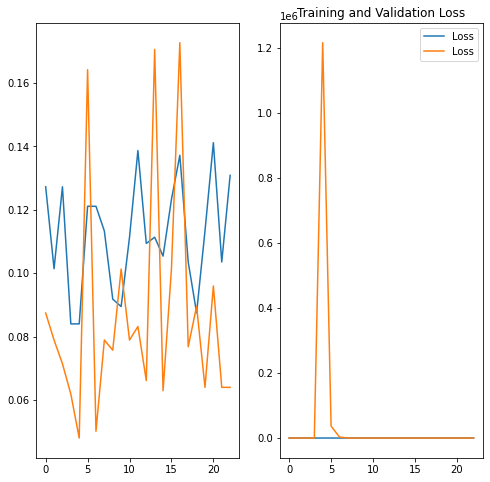

In [ ]:
acc = v4_history.history['accuracy']
acc_val = v4_history.history['val_accuracy']
loss=v4_history.history['loss']
loss_val=v4_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc,acc_val, label='Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, loss_val,label='Loss')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 실행

In [ ]:
def img_preprocess(img):
    img = img.convert('RGB').resize((100,100))
    img = np.array(img)

    img = img.reshape((100,100,3))
    plt.imshow(img)
    
    img= [img]
    img = np.array(img)
    img = img/255

    return img

In [ ]:
animal_class = {'chicken': 0,
 'cow': 1,
 'dog': 2,
 'horse': 3,
 'monkey': 4,
 'mouse': 5,
 'pig': 6,
 'rabbit': 7,
 'sheep': 8,
 'snake': 9,
 'tiger': 10}

In [ ]:
## load model
use_model = keras.models.load_model('/content/drive/Shareddrives/dataset/test_inceptionv3_0121_2.h5')

In [ ]:
use_img = keras.preprocessing.image.load_img('/content/drive/Shareddrives/dataset/example/22 (10).jpg',target_size=(200,200))

## Predict

100.0 % monkey 상 입니다.

0.0 % dog 상 입니다.
0.0 % pig 상 입니다.
0.0 % rabbit 상 입니다.


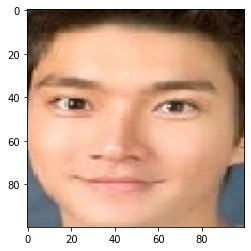

In [ ]:
use_img = keras.preprocessing.image.load_img('/content/drive/Shareddrives/dataset/example/22 (25).jpg',target_size=(100,100))

pred = use_model.predict(img_preprocess(use_img))
pred_i = np.argmax(pred)
#print(f'예측 점수:{pred},\n\n인덱스: {pred_i}\n\n')
for key, value in animal_class.items():
    if pred_i == value:
        print(round((np.max(pred)*100),2),'%',f'{key} 상 입니다.\n')
top3 = np.sort(pred[0])[::-1][1:4]

for s in top3:
    idx = list(pred[0]).index(s)
    for key,value in animal_class.items():
        if idx == value:
            print(round(s*100,2),'%',f'{key} 상 입니다.')

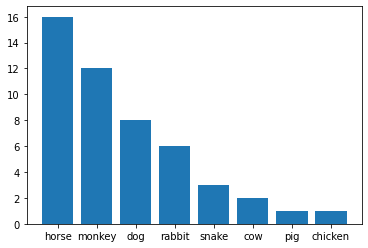

In [ ]:
monkey = 12
pig = 1
horse = 16
chicken = 1
#cow = 1
dog = 8
snake = 3
rabbit = 6
cow = 2


from matplotlib import pyplot as plt
values =  [16,12,8,6,3,2,1,1]
x = np.arange(8)

plt.bar(x, values)
plt.xticks(x,['horse','monkey','dog','rabbit','snake','cow','pig','chicken'])
plt.show()